In [98]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.data import Dataset
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Flatten, GaussianNoise, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping

import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import jupyterthemes as jt
from sklearn.model_selection import train_test_split

jt.jtplot.style()

""" Avoid error with Blas:GEMM not initializing when using GPU:
See: https://stackoverflow.com/questions/43990046/tensorflow-blas-gemm-launch-failed
"""
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

tf.random.set_seed(98)
np.random.seed(99)

In [40]:
def rounding_accuracy(y_true, y_pred):
    """Rounds both target and output to 0,1 and calculates the accuracy"""
    round_true = tf.math.round(y_true)
    round_preds = tf.math.round(y_pred)
    return tf.metrics.binary_accuracy(round_true, round_preds)

def plot_image(image, cmap="binary"):
    plt.imshow(image, cmap=cmap)
    plt.axis("off")
    
def show_reconstructions(model, images, n_images=5, cmap="binary"):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index], cmap=cmap)
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index], cmap=cmap)

def plot_history(history, acc="rounding_accuracy"):
    loss, val_loss = history["loss"], history["val_loss"]
    acc, val_acc = history[acc], history[f"val_{acc}"]
    n_epochs = range(len(loss))
    
    fig, (ax1, ax2) = plt.subplots(figsize=(12, 6), nrows=1, ncols=2)
    
    ax1.plot(n_epochs, loss, label="train")
    ax1.plot(n_epochs, val_loss, label="validation")
    ax1.set_ylabel("loss")
    ax1.set_xlabel("epoch")
    ax1.legend()

    ax2.plot(n_epochs, acc, label="train")
    ax2.plot(n_epochs, val_acc, label="validation")
    ax2.set_ylabel("accuracy")
    ax2.legend()

    plt.show()


# Exercise 9
## Try using a denoising autoencoder to pre-train an image classifier
### a) Use MNIST (simplest option)

In [66]:
(X_train_full, y_train_full), (X_test_full, y_test_full) = mnist.load_data()

train_size = 55000

X_train_scaled, X_test_scaled = X_train_full / 255., X_test_full / 255.
X_train, y_train = X_train_scaled[:train_size], y_train_full[:train_size]
X_valid, y_valid = X_train_scaled[train_size:], y_train_full[train_size:]

### Denoising Autoencoder

In [77]:
codings_size = 50
batch_size = 32

encoder = Sequential([
    Flatten(input_shape=[28, 28]),
    GaussianNoise(0.3),
    Dense(100, activation="selu"),
    Dense(codings_size, activation="selu")
])
decoder = Sequential([
    Dense(100, activation="selu", input_shape=[codings_size]),
    Dense(28*28, activation="sigmoid"),
    Reshape([28, 28])
])
autoencoder = Sequential([encoder, decoder])
autoencoder.compile(loss="binary_crossentropy", optimizer="adam", metrics=[rounding_accuracy])
history = autoencoder.fit(
    X_train_scaled, X_train_scaled,
    validation_data=(X_test_scaled, X_test_scaled),
    batch_size=32, epochs=6)

Epoch 1/6
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1877 - rounding_accuracy: 0.9160 - val_loss: 0.1039 - val_rounding_accuracy: 0.9640
Epoch 2/6
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1128 - rounding_accuracy: 0.9583 - val_loss: 0.0958 - val_rounding_accuracy: 0.9688
Epoch 3/6
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1072 - rounding_accuracy: 0.9615 - val_loss: 0.0923 - val_rounding_accuracy: 0.9710
Epoch 4/6
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1048 - rounding_accuracy: 0.9630 - val_loss: 0.0905 - val_rounding_accuracy: 0.9720
Epoch 5/6
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1030 - rounding_accuracy: 0.9640 - val_loss: 0.0891 - val_rounding_accuracy: 0.9731
Epoch 6/6
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1013 - rounding_accuracy: 0.9651 - val_loss: 0.0876 - val_rounding_accuracy: 0.9739


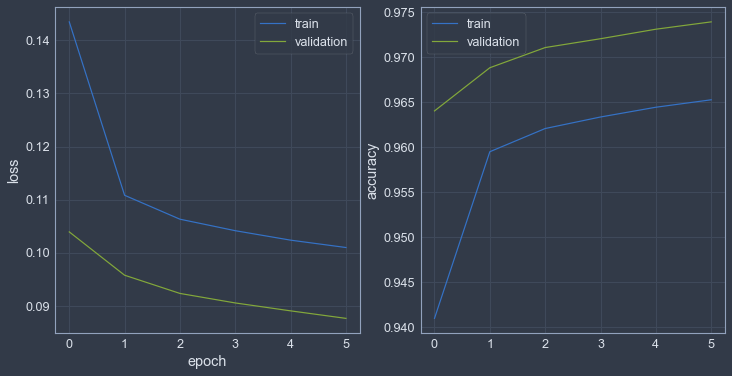

In [78]:
plot_history(history.history)

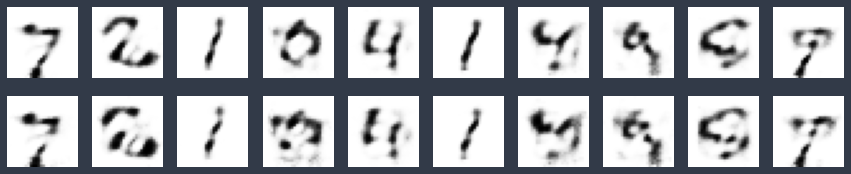

In [79]:
images = model.predict(X_test_scaled)
show_reconstructions(model, images, 10)

## Classifier trained on small sample

Randomly sample some 500 data points

In [80]:
sample_idx = np.random.choice(range(len(X_train)), 500)
X_train_sample = X_train[sample_idx]
y_train_sample = y_train[sample_idx]

Check the labels are more or less balanced

In [81]:
np.unique(y_train_sample, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([56, 62, 44, 60, 49, 46, 51, 40, 39, 53], dtype=int64))

### Supervised model trained on this small sample

In [82]:
supervised = Sequential([
    Flatten(input_shape=[28, 28]),
    Dense(300, activation="selu"),
    Dense(100, activation="selu"),    
    Dense(30, activation="selu"),
    Dense(10, activation="softmax")
])
supervised.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = supervised.fit(
    X_train_sample, y_train_sample,
    validation_data=(X_valid, y_valid),
    epochs=20, batch_size=16)

Epoch 1/20
32/32 [==============================] - 1s 27ms/step - loss: 1.8167 - accuracy: 0.4715 - val_loss: 0.5564 - val_accuracy: 0.8322
Epoch 2/20
32/32 [==============================] - 1s 23ms/step - loss: 0.3686 - accuracy: 0.8864 - val_loss: 0.4599 - val_accuracy: 0.8618
Epoch 3/20
32/32 [==============================] - 1s 22ms/step - loss: 0.2087 - accuracy: 0.9570 - val_loss: 0.4824 - val_accuracy: 0.8496
Epoch 4/20
32/32 [==============================] - 1s 23ms/step - loss: 0.0973 - accuracy: 0.9831 - val_loss: 0.4220 - val_accuracy: 0.8788
Epoch 5/20
32/32 [==============================] - 1s 22ms/step - loss: 0.0702 - accuracy: 0.9885 - val_loss: 0.4495 - val_accuracy: 0.8788
Epoch 6/20
32/32 [==============================] - 1s 22ms/step - loss: 0.0363 - accuracy: 1.0000 - val_loss: 0.4391 - val_accuracy: 0.8792
Epoch 7/20
32/32 [==============================] - 1s 24ms/step - loss: 0.0186 - accuracy: 1.0000 - val_loss: 0.4417 - val_accuracy: 0.8810
Epoch 8/20
32

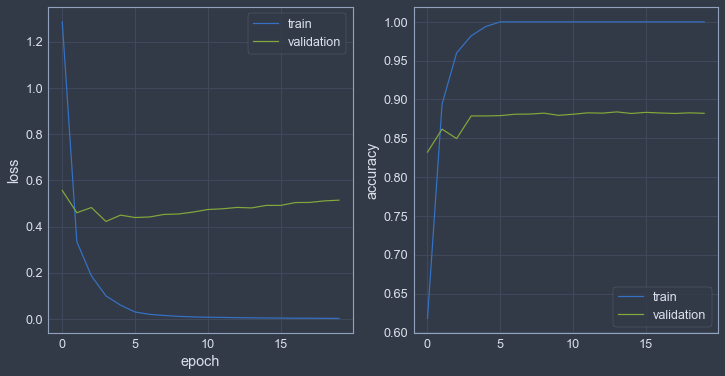

In [83]:
plot_history(history.history, "accuracy")

### Pre-trained model

In [84]:
classifier = Sequential([
    encoder,
    Dense(100, activation="selu"),
    Dense(10, activation="softmax")
])
classifier.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = classifier.fit(
    X_train_sample, y_train_sample, 
    validation_data=(X_valid, y_valid),
    epochs=20, batch_size=16)

Epoch 1/20
32/32 [==============================] - 1s 27ms/step - loss: 4.0308 - accuracy: 0.2175 - val_loss: 1.1868 - val_accuracy: 0.6010
Epoch 2/20
32/32 [==============================] - 1s 23ms/step - loss: 0.9153 - accuracy: 0.6818 - val_loss: 0.7645 - val_accuracy: 0.7552
Epoch 3/20
32/32 [==============================] - 1s 22ms/step - loss: 0.6126 - accuracy: 0.8346 - val_loss: 0.6035 - val_accuracy: 0.7978
Epoch 4/20
32/32 [==============================] - 1s 23ms/step - loss: 0.3932 - accuracy: 0.8720 - val_loss: 0.4967 - val_accuracy: 0.8398
Epoch 5/20
32/32 [==============================] - 1s 23ms/step - loss: 0.3740 - accuracy: 0.8925 - val_loss: 0.4837 - val_accuracy: 0.8494
Epoch 6/20
32/32 [==============================] - 1s 22ms/step - loss: 0.3514 - accuracy: 0.9018 - val_loss: 0.4371 - val_accuracy: 0.8668
Epoch 7/20
32/32 [==============================] - 1s 23ms/step - loss: 0.2385 - accuracy: 0.9293 - val_loss: 0.4247 - val_accuracy: 0.8734
Epoch 8/20
32

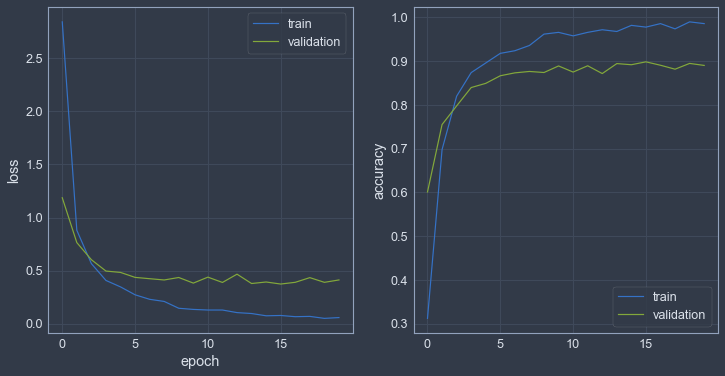

In [85]:
plot_history(history.history, "accuracy")

The pre-trained model attained better results as well as being less overfit to the data!

### b) Use CIFAR-10 (bigger challenge)

In [146]:
(X_train_full, y_train_full), (X_test, y_test) = cifar10.load_data()

train_size = 45000

X_train_scaled, X_test_scaled = X_train_full / 255., X_test / 255.
X_train, y_train = X_train_scaled[:train_size], y_train_full[:train_size]
X_valid, y_valid = X_train_scaled[train_size:], y_train_full[train_size:]

I tried using Dropout(0.5) below but it didn't seem to work well. Perhaps should've decreased the # of inputs being dropped out, but GaussianNoise seems to work well

In [147]:
codings_size = 64
kernel_size = 3

conv_encoder = Sequential([
    Input(shape=[32, 32, 3]),
    GaussianNoise(0.3),
    Conv2D(16, kernel_size=kernel_size, padding="same", activation="selu", input_shape=[32, 32, 3]),
    MaxPool2D(pool_size=2), #16x16
    Conv2D(32, kernel_size=kernel_size, padding="same", activation="selu"),
    MaxPool2D(pool_size=2), #8x8
    Conv2D(codings_size, kernel_size=kernel_size, padding="same", activation="selu"),
    MaxPool2D(pool_size=2), #4x4
])
conv_decoder = Sequential([
    Conv2DTranspose(32, kernel_size=kernel_size, strides=2, padding="same", activation="selu",
                   input_shape=[4, 4, codings_size]),
    Conv2DTranspose(16, kernel_size=kernel_size, strides=2, padding="same", activation="selu"),
    Conv2DTranspose(3, kernel_size=kernel_size, strides=2, padding="same", activation="sigmoid"),
    Reshape([32, 32, 3])
])
conv_autoencoder = Sequential([conv_encoder, conv_decoder])
conv_autoencoder.compile(loss="binary_crossentropy", metrics=[rounding_accuracy],
                         optimizer=Adam(lr=1e-3))

In [172]:
conv_encoder.save("saved_models/17_autoencoders/cifar_conv_encoder.h5")

In [148]:
history = conv_autoencoder.fit(
    X_train, X_train, 
    validation_data=(X_valid, X_valid),
    epochs=10, batch_size=32,
    callbacks=[EarlyStopping(patience=3)])

Epoch 1/10
1407/1407 [==============================] - 10s 6ms/step - loss: 0.5947 - rounding_accuracy: 0.8328 - val_loss: 0.7073 - val_rounding_accuracy: 0.7770
Epoch 2/10
1407/1407 [==============================] - 9s 6ms/step - loss: 0.5724 - rounding_accuracy: 0.8831 - val_loss: 0.5968 - val_rounding_accuracy: 0.8817
Epoch 3/10
1407/1407 [==============================] - 9s 6ms/step - loss: 0.5706 - rounding_accuracy: 0.8875 - val_loss: 0.5942 - val_rounding_accuracy: 0.8788
Epoch 4/10
1407/1407 [==============================] - 9s 6ms/step - loss: 0.5698 - rounding_accuracy: 0.8898 - val_loss: 0.5783 - val_rounding_accuracy: 0.8945
Epoch 5/10
1407/1407 [==============================] - 9s 6ms/step - loss: 0.5695 - rounding_accuracy: 0.8916 - val_loss: 0.5713 - val_rounding_accuracy: 0.9052
Epoch 6/10
1407/1407 [==============================] - 9s 6ms/step - loss: 0.5687 - rounding_accuracy: 0.8928 - val_loss: 0.5672 - val_rounding_accuracy: 0.9083
Epoch 7/10
1407/1407 [=====

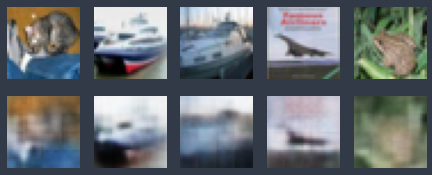

In [149]:
show_reconstructions(conv_autoencoder, X_test_scaled, n_images=5, cmap=None)

Pretty blurry, but considering it is re-creating these images from a 4x4 image it isn't too shabby

### Creating classifiers

In [150]:
sample_idx = np.random.choice(range(len(X_train)), 500)
X_train_sample = X_train[sample_idx]
y_train_sample = y_train[sample_idx]

In [151]:
np.unique(y_train_sample, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([60, 52, 54, 35, 55, 43, 38, 48, 60, 55], dtype=int64))

In [182]:
kernel_size = 3
supervised = Sequential([
    Conv2D(64, kernel_size=kernel_size, padding="same", activation="selu", input_shape=[32, 32, 3]),
    MaxPool2D(pool_size=2),
    Conv2D(128, kernel_size=kernel_size, padding="same", activation="selu"),
    MaxPool2D(pool_size=2),
    Conv2D(256, kernel_size=kernel_size, padding="same", activation="selu"),
    MaxPool2D(pool_size=2),
    Flatten(),
    Dense(128, activation="selu"),
    Dense(64, activation="selu"),
    Dense(10, activation="softmax")])
supervised.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = supervised.fit(
    X_train_sample, y_train_sample,
    validation_data=(X_valid, y_valid),
    epochs=50, batch_size=16,
    callbacks=EarlyStopping(patience=5)
)

Epoch 1/50
32/32 [==============================] - 2s 37ms/step - loss: 3.7100 - accuracy: 0.1339 - val_loss: 2.1802 - val_accuracy: 0.2332
Epoch 2/50
32/32 [==============================] - 1s 31ms/step - loss: 2.0106 - accuracy: 0.3089 - val_loss: 1.9723 - val_accuracy: 0.3096
Epoch 3/50
32/32 [==============================] - 1s 32ms/step - loss: 1.7112 - accuracy: 0.4131 - val_loss: 1.9079 - val_accuracy: 0.3338
Epoch 4/50
32/32 [==============================] - 1s 31ms/step - loss: 1.5789 - accuracy: 0.4932 - val_loss: 1.8144 - val_accuracy: 0.3616
Epoch 5/50
32/32 [==============================] - 1s 32ms/step - loss: 1.1523 - accuracy: 0.6577 - val_loss: 1.7606 - val_accuracy: 0.3856
Epoch 6/50
32/32 [==============================] - 1s 31ms/step - loss: 0.8634 - accuracy: 0.7295 - val_loss: 1.8581 - val_accuracy: 0.3852
Epoch 7/50
32/32 [==============================] - 1s 32ms/step - loss: 0.4941 - accuracy: 0.8804 - val_loss: 2.0949 - val_accuracy: 0.3634
Epoch 8/50
32

Not great

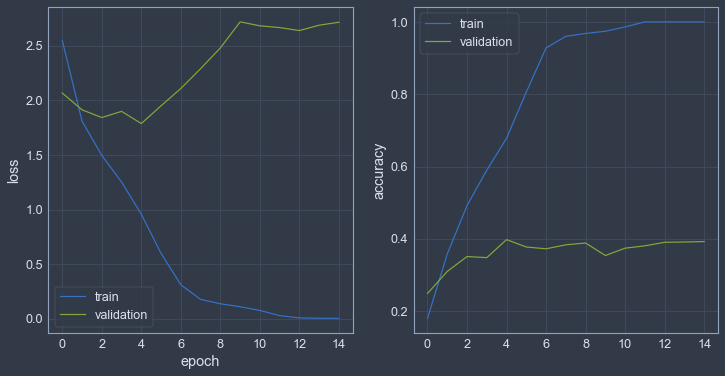

In [160]:
plot_history(history.history, "accuracy")

In [183]:
# Reload encoder so that weights aren't affected when re-training
conv_encoder = tf.keras.models.load_model("saved_models/17_autoencoders/cifar_conv_encoder.h5")
pre_trained = Sequential([
    conv_encoder,
    Flatten(),
    Dense(128, activation="selu"),
    Dense(64, activation="selu"),
    Dense(10, activation="softmax")
])
pre_trained.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = pre_trained.fit(
    X_train_sample, y_train_sample,
    validation_data=(X_valid, y_valid),
    epochs=50, batch_size=16,
    callbacks=EarlyStopping(patience=5)
)

Epoch 1/50
32/32 [==============================] - 1s 34ms/step - loss: 3.0752 - accuracy: 0.1266 - val_loss: 2.0964 - val_accuracy: 0.2626
Epoch 2/50
32/32 [==============================] - 1s 27ms/step - loss: 1.8609 - accuracy: 0.3578 - val_loss: 2.0211 - val_accuracy: 0.2936
Epoch 3/50
32/32 [==============================] - 1s 30ms/step - loss: 1.6574 - accuracy: 0.4271 - val_loss: 2.2700 - val_accuracy: 0.2756
Epoch 4/50
32/32 [==============================] - 1s 28ms/step - loss: 1.4814 - accuracy: 0.4743 - val_loss: 2.0262 - val_accuracy: 0.2982
Epoch 5/50
32/32 [==============================] - 1s 28ms/step - loss: 1.4913 - accuracy: 0.4700 - val_loss: 1.9607 - val_accuracy: 0.3190
Epoch 6/50
32/32 [==============================] - 1s 29ms/step - loss: 1.2325 - accuracy: 0.5942 - val_loss: 2.1702 - val_accuracy: 0.3038
Epoch 7/50
32/32 [==============================] - 1s 28ms/step - loss: 1.1328 - accuracy: 0.6044 - val_loss: 2.0555 - val_accuracy: 0.3346
Epoch 8/50
32

Struggling with this exercise, tough to create a good Convolutional model with only 500 samples

# 10)
### Train a Variational Autoencoder on the dataset of your choice and use it to generate images